In [24]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pylab import *
import seaborn as sns
import pickle
import numpy as np
from glob import glob

import MDAnalysis as mda
import MDAnalysis.analysis.hole
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.hole import HOLE, HOLEtraj


In [2]:
def regularized_function(x, y, func, bins=100, range=None):
    """Compute *func()* over data aggregated in bins.
    ``(x,y) --> (x', func(Y'))``  with ``Y' = {y: y(x) where x in x' bin}``
    First the data is collected in bins x' along x and then *func* is
    applied to all data points Y' that have been collected in the bin.
    .. function:: func(y) -> float
       *func* takes exactly one argument, a numpy 1D array *y* (the
       values in a single bin of the histogram), and reduces it to one
       scalar float.
    .. Note:: *x* and *y* must be 1D arrays.
    :Arguments:
       x
          abscissa values (for binning)
       y
          ordinate values (func is applied)
       func
          a numpy ufunc that takes one argument, func(Y')
       bins
          number or array
       range
          limits (used with number of bins)
    :Returns:
       F,edges
          function and edges (``midpoints = 0.5*(edges[:-1]+edges[1:])``)
    (This function originated as
    :func:`recsql.sqlfunctions.regularized_function`.)
    """
    _x = np.asarray(x)
    _y = np.asarray(y)

    if len(_x.shape) != 1 or len(_y.shape) != 1:
        raise TypeError("Can only deal with 1D arrays.")

    # setup of bins (taken from numpy.histogram)
    if (range is not None):
        mn, mx = range
        if (mn > mx):
            raise AttributeError('max must be larger than min in range parameter.')

    if not np.iterable(bins):
        if range is None:
            range = (_x.min(), _x.max())
        mn, mx = [float(mi) for mi in range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = np.linspace(mn, mx, bins+1, endpoint=True)
    else:
        bins = np.asarray(bins)
        if (np.diff(bins) < 0).any():
            raise ValueError('bins must increase monotonically.')

    sorting_index = np.argsort(_x)
    sx = _x[sorting_index]
    sy = _y[sorting_index]

    # boundaries in SORTED data that demarcate bins; position in bin_index is the bin number
    bin_index = np.r_[sx.searchsorted(bins[:-1], 'left'),
                         sx.searchsorted(bins[-1], 'right')]

    # naive implementation: apply operator to each chunk = sy[start:stop] separately
    #
    # It's not clear to me how one could effectively block this procedure (cf
    # block = 65536 in numpy.histogram) because there does not seem to be a
    # general way to combine the chunks for different blocks, just think of
    # func=median
    F = np.zeros(len(bins)-1)  # final function
    F[:] = [func(sy[start:stop]) for start,stop in zip(bin_index[:-1],bin_index[1:])]
    return F,bins


In [3]:
open_xray = HOLE("../../1-Trajectories/0-Parm_rst/open10_dry.pdb", endrad=5,\
                   sample=0.1, cvect=[0,0,-1], executable="/home/el14718/Software/hole2/exe/hole") 
open_xray.run()
open_xray.collect()
open_xray.create_vmd_surface(filename='hole_open_xray.vmd')

'hole_open_xray.vmd'

In [4]:
%cp hole.sph hole_open.sph

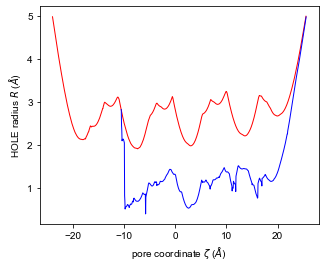

In [5]:
closed_xray = HOLE("../../1-Trajectories/0-Parm_rst/closed6_dry_rot0.pdb", endrad=5,
                   sphpdb="./hole_open.sph", sample=0.1, cvect=[0,0,1], 
                   executable="/home/el14718/Software/hole2/exe/hole") 
closed_xray.run()
closed_xray.collect()
closed_xray.create_vmd_surface(filename='hole_closed_xray.vmd')


fig, ax = plt.subplots(figsize=(5,4))
ax = open_xray.plot(linewidth=1, color="red", label=False)
ax = closed_xray.plot(linewidth=1, color="blue", label=False)

# ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
# ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

# ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

# ax.set_xticks(np.arange(0, 5, 0.5))
# ax.set_yticks(np.arange(0, 5, 0.5))

# fig.savefig('./plots/1-With_IPA/2_initial_FES.png', dpi=600)

In [15]:
def hole_calc(topfile, t, step):
    clust = mda.Universe(topfile, t)
    H_clust = HOLEtraj(clust , step=step, endrad=5, sample=0.1, cvect=[0,0,1], \
                 executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
    H_clust.run()
    
    rxncoord = np.concatenate([profile.rxncoord for frame, profile in H_clust.sorted_profiles_iter()])
    radii = np.concatenate([profile.radius for frame, profile in H_clust.sorted_profiles_iter()])

    mean_r, q = regularized_function(rxncoord, radii, np.mean, bins=100)
    std_r, q = regularized_function(rxncoord, radii, np.std, bins=100)
    zeta = 0.5*(q[1:] + q[:-1])
    
    return zeta, mean_r,std_r

In [38]:
topfile='../../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7'

traj_list_ipa=sorted(glob("../sample_structures/1-With_IPA/2-MSM_1000_samples_aligned/pcca*.xtc"))

zeta_list_ipa=[]
mean_r_list_ipa=[]
std_r_list_ipa=[]

for t in traj_list_ipa:
    zeta, mean_r,std_r=hole_calc(topfile, t, 1)
    zeta_list_ipa.append(zeta)
    mean_r_list_ipa.append(mean_r)
    std_r_list_ipa.append(std_r)
    print(t[-5]+" done!")

/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


1 done!
2 done!
3 done!
4 done!
5 done!


In [43]:
with open('../pickled/1-With_IPA/hole_zeta.pickle', 'wb') as outf:
    pickle.dump(zeta_list_ipa, outf)
with open('../pickled/1-With_IPA/hole_mean_r.pickle', 'wb') as outf:
    pickle.dump(mean_r_list_ipa, outf)
with open('../pickled/1-With_IPA/hole_std_r.pickle', 'wb') as outf:
    pickle.dump(std_r_list_ipa, outf)
    
# with open('./pickled/1-With_IPA/1_msm.pickle', 'rb') as inf:
#     msm = pickle.load(inf)

In [52]:
topfile='../../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7'

traj_list=sorted(glob("../sample_structures/2-Without_IPA/2-MSM_1000_samples_aligned/pcca*.xtc"))

zeta_list=[]
mean_r_list=[]
std_r_list=[]

for t in traj_list:
    zeta, mean_r,std_r=hole_calc(topfile, t, 1)
    zeta_list.append(zeta)
    mean_r_list.append(mean_r)
    std_r_list.append(std_r)
    print(t[-5]+" done!")

/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/el14718/Software/anaconda3_2019/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


1 done!
2 done!
3 done!
4 done!
5 done!
6 done!


In [53]:
with open('../pickled/2-Without_IPA/hole_zeta.pickle', 'wb') as outf:
    pickle.dump(zeta_list, outf)
with open('../pickled/2-Without_IPA/hole_mean_r.pickle', 'wb') as outf:
    pickle.dump(mean_r_list, outf)
with open('../pickled/2-Without_IPA/hole_std_r.pickle', 'wb') as outf:
    pickle.dump(std_r_list, outf)
    
# with open('./pickled/1-With_IPA/1_msm.pickle', 'rb') as inf:
#     msm = pickle.load(inf)

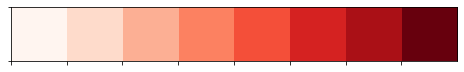

In [33]:
hexlist=[]

cmap = cm.get_cmap("Reds", 8)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
sns.set_palette(hexlist)
sns.palplot(sns.color_palette())
# my_cmap_ipa=ListedColormap([hexlist[6],hexlist[3],hexlist[2],hexlist[4],hexlist[5]])
my_cmap_ipa=[hexlist[6],hexlist[3],hexlist[2],hexlist[4],hexlist[5]]

In [32]:
hexlist

['#fff5f0',
 '#fedbcb',
 '#fcaf94',
 '#fc8161',
 '#f44f39',
 '#d52221',
 '#aa1016',
 '#67000d']

[(0.0, 3.5), (-22.0, 23.0)]

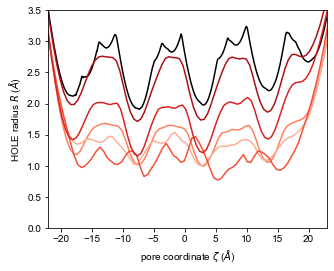

In [44]:
fig, ax = plt.subplots(figsize=(5,4))
for i in range(0,5):
#     ax.fill_between(zeta_list_ipa[i], mean_r_list_ipa[i] - std_r_list_ipa[i], 
#                 mean_r_list_ipa[i] + std_r_list_ipa[i], color="blue", alpha=0.2)
    ax.plot(zeta_list_ipa[i], mean_r_list_ipa[i], color=my_cmap_ipa[i], lw=1.5)

ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"Radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1.5, color='k', label=False)
ax.set(xlim=(-22, 23) , ylim=(0, 3.5))

[(0.0, 3.5), (-22.0, 23.0)]

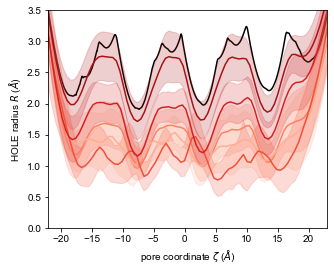

In [45]:
fig, ax = plt.subplots(figsize=(5,4))
for i in range(0,5):
    ax.fill_between(zeta_list_ipa[i], mean_r_list_ipa[i] - std_r_list_ipa[i], 
                mean_r_list_ipa[i] + std_r_list_ipa[i], color=my_cmap_ipa[i], alpha=0.2)
    ax.plot(zeta_list_ipa[i], mean_r_list_ipa[i], color=my_cmap_ipa[i], lw=1.5)

ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"Radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1.5, color='k', label=False)
ax.set(xlim=(-22, 23) , ylim=(0, 3.5))

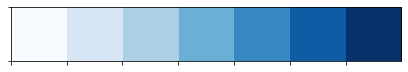

In [46]:
hexlist=[]

cmap = cm.get_cmap("Blues",7)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
sns.set_palette(hexlist)
sns.palplot(sns.color_palette())
my_cmap=[hexlist[2],hexlist[1],hexlist[3],hexlist[4],hexlist[5],hexlist[6]]

[(0.0, 3.5), (-22.0, 23.0)]

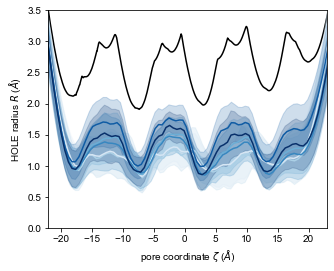

In [54]:
fig, ax = plt.subplots(figsize=(5,4))
for i in range(0,6):
    ax.fill_between(zeta_list[i], mean_r_list[i] - std_r_list[i], 
                mean_r_list[i] + std_r_list[i], color=my_cmap[i], alpha=0.2)
    ax.plot(zeta_list[i], mean_r_list[i], color=my_cmap[i], lw=1.5)

ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"Radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1.5, color='k', label=False)
ax.set(xlim=(-22, 23) , ylim=(0, 3.5))

[(0.0, 3.5), (-22.0, 23.0)]

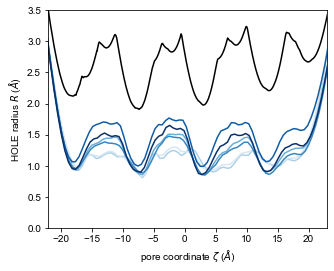

In [55]:
fig, ax = plt.subplots(figsize=(5,4))
for i in range(0,6):
#     ax.fill_between(zeta_list[i], mean_r_list[i] - std_r_list[i], 
#                 mean_r_list[i] + std_r_list[i], color=my_cmap[i], alpha=0.2)
    ax.plot(zeta_list[i], mean_r_list[i], color=my_cmap[i], lw=1.5)

ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"Radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1.5, color='k', label=False)
ax.set(xlim=(-22, 23) , ylim=(0, 3.5))

In [50]:
len(zeta_list)

0